In [1]:
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten,UpSampling2D,Conv2DTranspose
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add,Add,concatenate,Concatenate
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import HTML, display, clear_output, SVG
import pydot
import graphviz
from keras.applications import VGG19
import glob
import cv2 as cv
import warnings


Using TensorFlow backend.
C:\Users\Sam\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sam\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sam\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sam\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [5]:
input_image=Input(shape=(25,25,3))
conv_layer=Conv2D(filters=64,kernel_size=(9,9),strides=(1,1),padding='same')(input_image)
input_block=PReLU()(conv_layer)


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
def res_block(inp):
    block=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(inp)
    block=BatchNormalization()(block)
    block=PReLU()(block)
    block=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(block)
    block=BatchNormalization()(block)
   
    return Add()([inp,block])
    

In [7]:
#input_image=Input(shape=(256,256,3))
generative_model=input_block
blocks=5
for i in range(blocks):
    generative_model=res_block(generative_model)

block=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(generative_model)
block=BatchNormalization()(block)
generative_model=Add()([input_block,block])

block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(generative_model)
block=UpSampling2D(size=(2,2),interpolation='nearest')(block)
block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(block)
block=UpSampling2D(size=(2,2),interpolation='nearest')(block)
block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(block)
block=PReLU()(block)

block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(generative_model)
block=UpSampling2D(size=(2,2),interpolation='nearest')(block)
block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(block)
block=UpSampling2D(size=(2,2),interpolation='nearest')(block)
block=Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(block)
block=PReLU()(block)

generative_model=Conv2D(filters=3,kernel_size=(9,9),strides=(1,1),padding='same')(block)


 
generative_model=Model(input_image,generative_model)

In [8]:
#generative_model.summary()

In [10]:
#plot_model(generative_model, to_file='model.png')
#SVG(model_to_dot(generative_model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [11]:
disc_inp_image=Input(shape=(100,100,3))
disc_first_block=Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid')(disc_inp_image)
discriminator_model=LeakyReLU()(disc_first_block)

In [12]:
def disc_block(pre_layers,filters_value,stride_value):
    block=Conv2D(filters=filters_value,kernel_size=(3,3),strides=(stride_value,stride_value),padding='same')(pre_layers)
    block=BatchNormalization()(block)
    block=LeakyReLU()(block)
    
    return block

In [13]:
filters_list=[64,128,128,256,256,512,512]
strides_list=[2,1,2,1,2,1,2]

for i,j in zip(filters_list,strides_list):
    discriminator_model=disc_block(discriminator_model,i,j)
    
discriminator_model=Flatten()(discriminator_model)
discriminator_model=Dense(1024)(discriminator_model)
discriminator_model=LeakyReLU()(discriminator_model)
discriminator_model=Dense(1 ,activation='sigmoid')(discriminator_model)

discriminator_model=Model(disc_inp_image,discriminator_model)
discriminator_model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])


In [14]:
#discriminator_model.summary()

In [15]:
#plot_model(discriminator_model,'disc_model.png')
#SVG(model_to_dot(discriminator_model,show_layer_names=True,show_shapes=True,rankdir='TB').create(prog="dot",format='svg'))

In [2]:
def vgg_model():
    input_shape=Input(shape=(100,100,3))
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]
    vgg_output_layer10=vgg(input_shape)
    
    return Model(input_shape,vgg_output_layer10)

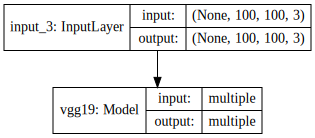

In [4]:
vgg=vgg_model()
SVG(model_to_dot(vgg,show_layer_names=True,show_shapes=True,rankdir='TB').create(prog="dot",format='svg'))

In [18]:
def srgan():
    input_shape=Input(shape=(25,25,3))
    disc_input_shape=Input(shape=(100,100,3))
    
    #vgg=vgg_model()
    vgg.trainable=False
    discriminator_model.trainable=False
    
    gen_image=generative_model(input_shape)
    vgg_features=vgg(gen_image)
    disc_value=discriminator_model(gen_image)
    
    return Model([input_shape,disc_input_shape],[vgg_features,disc_value])
    
    

In [19]:
SRGAN=srgan()
SRGAN.compile(loss=['binary_crossentropy','mse'],loss_weights=[1e-3,1],optimizer='adam')

In [76]:
SRGAN.summary()                                                                                          

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 25, 25, 3)    0                                            
__________________________________________________________________________________________________
model_16 (Model)                (None, 100, 100, 3)  4614723     input_33[0][0]                   
__________________________________________________________________________________________________
model_21 (Model)                (None, 25, 25, 256)  143667240   model_16[2][0]                   
__________________________________________________________________________________________________
model_17 (Model)                (None, 1)            30384961    model_16[2][0]                   
Total params: 178,666,924
Trainable params: 4,613,315
Non-trainable params: 174,053,609
_____________________

In [20]:
#SVG(model_to_dot(SRGAN,show_layer_names=True,show_shapes=True,rankdir='TB').create(prog="dot",format='svg'))

In [21]:
#SRGAN.summary()

In [22]:
#plot_model(SRGAN,'SRGAN_model.png')
#SVG(model_to_dot(SRGAN,show_layer_names=True,show_shapes=True,rankdir='TB').create(prog="dot",format='svg'))

In [23]:
dataset_folder_path=r'dataset'
train_hr_folder=r'\train\hr\*'
test_hr_folder=r'\test\hr\*'
train_lr_folder=r'\train\lr\*'
test_lr_folder=r'\test\lr\*'


In [24]:
hr_train_images_paths=glob.glob(dataset_folder_path+train_hr_folder)
hr_test_images_paths=glob.glob(dataset_folder_path+test_hr_folder)
lr_train_images_paths=glob.glob(dataset_folder_path+train_lr_folder)
lr_test_images_paths=glob.glob(dataset_folder_path+test_lr_folder)

In [25]:
len(hr_train_images_paths),len(hr_test_images_paths) ,len(lr_train_images_paths),len(lr_test_images_paths)

(2500, 500, 2500, 500)

In [26]:
hr_train_images_paths.sort()
hr_test_images_paths.sort()
lr_train_images_paths.sort()
lr_test_images_paths.sort()

In [60]:
hr_train_images=[]
lr_train_images=[]
hr_test_images=[]
lr_test_images=[]
for path1,path2 in zip(hr_train_images_paths,lr_train_images_paths):
    img1=cv.imread(path1)/255
    img2=cv.imread(path2)/255
    hr_train_images.append(img1)
    lr_train_images.append(img2)
for path1,path2 in zip(hr_test_images_paths,lr_test_images_paths):
    img1=cv.imread(path1)/255
    img2=cv.imread(path2)/255
    hr_test_images.append(img1)
    lr_test_images.append(img2) 

In [61]:
#(hr_train_images.shape,lr_train_images.shape),(hr_test_images.shape,lr_test_images.shape)

In [66]:
len(hr_train_images)

2500

In [67]:
epochs=20
batch_size=15
train_steps_per_epoch=int(np.ceil(len(hr_train_images)/batch_size))
test_steps_per_epoch=int(np.ceil(len(hr_test_images)/batch_size))

In [86]:

hr_train_batches=[]
hr_test_batches=[]
lr_train_batches=[]
lr_test_batches=[]



for i in range(train_steps_per_epoch):
    hr_train_batches.append(hr_train_images[batch_size*i:(i+1)*batch_size])
    lr_train_batches.append(lr_train_images[batch_size*i:(i+1)*batch_size])        

for i in range(epochs):
    g_losses=[]
    d_losses=[]
    gen_lable=np.zero((batch_size,1))
    real_lable=np.ones((batch_size,1))    
    for j in range(train_steps_per_epoch):
        hr_train_batch=np.array(hr_train_batches[j])
        lr_train_batch=np.array(lr_train_batches[j])

        
        gen_img=generative_model.predict(lr_train_batch)
        
        discriminator_model.trainable=True
        disc_loss1=discriminator_model.train_on_batch(gen_img ,gen_lable)
        disc_loss2=discriminator_model.train_on_batch(hr_train_batch,real_lable )
        
        discriminator_model.trainable = False
        vgg_features=vgg.predict(hr_train_batch)
        d_loss=0.5 * np.add(disc_loss1,disc_loss2)
        
        gen_loss,x,y = SRGAN.train_on_batch([lr_train_batch,hr_train_batch],[vgg_features,real_lable])
        
        g_losses.append(gen_loss)
        d_losses.append(d_loss)
    g_losses=np.array(g_losses)
    d_losses=np.array(d_losses)
    g_loss_per_epoch=np.sum(g_losses,axis=0)/len(g_losses)
    d_loss_per_epoch=np.sum(d_losses,axis=0)/len(d_losses)
    print('Epoch : ' + str(i+1) + 'Generative Loss : Discriminator Loss = ' + str(d_loss_per_epoch)+ ':' + str(d_loss_per_epoch))           
               

In [82]:
np.array(lr_train_batches[1]).shape

(15, 25, 25, 3)

In [13]:
input_shape=Input(shape=(100,100,3))
block=UpSampling2D(size=(2,2),interpolation='nearest')(input_shape)
#block=UpSampling2D(size=(2,2),interpolation='nearest')(block)
vgg = VGG19(weights="imagenet")(block)
#vgg.outputs = [vgg.layers[9].output]
#vgg_output_layer10=vgg(input_shape)
    
Model(input_shape,vgg).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 200, 200, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 1000)              143667240 
Total params: 143,667,240
Trainable params: 143,667,240
Non-trainable params: 0
_________________________________________________________________
